# REGALS analysis of CypA T-jump data

 **The data were originally reported in:**

 Thompson, M. C.; Barad, B. A.; Wolff, A. M.; Sun Cho, H.; Schotte, F.; Schwarz, D. M. C.; Anfinrud, P.; Fraser, J. S.  
 *Temperature-Jump Solution X-Ray Scattering Reveals Distinct Motions in a Dynamic Enzyme.*
 Nature Chemistry 2019, 11 (11), 1058-1066. <https://doi.org/10.1038/s41557-019-0329-3>.

 **The scattering profiles were downloaded from:** figshare on July 31,
 2020.
 <https://doi.org/10.35092/yhjc.9177143>

 **REGALS analysis script by:** Steve Meisburger, September 3, 2020

In [1]:
%matplotlib inline

import sys
import os
sys.path.append(os.path.abspath('../python/'))

import h5py
import numpy as np

from regals import *

import matplotlib.pyplot as plt

## Load data

In [2]:
CypA_Tjump = {}
with h5py.File('data/CypA_Tjump.mat', 'r') as f:
    for key in f:
        CypA_Tjump[key] = np.array(f[key])

#Store raw data
q = CypA_Tjump['q'][0]
I = CypA_Tjump['I'].T[:,1:]
sigma = CypA_Tjump['sigma'].T[:,1:]
delay_ns = CypA_Tjump['delay_ns'][0][1:]

## Set up REGALS calculation

Each component has a concentration and profile regularizer.

In [3]:
x = delay_ns.copy()
x = np.log10(x) # we're going to seek smoothness on a logarithmic scale

C1 = component(
    concentration_class('smooth', x, xmin = 2.749, xmax = 6.001, is_zero_at_xmin = True, is_zero_at_xmax = True, Nw = 31),
    profile_class('realspace',q, dmax = 59, Nw = 101))

C2 = component(
    concentration_class('smooth', x, xmin = 2.749, xmax = 6.001, is_zero_at_xmin = False, is_zero_at_xmax = False, Nw = 31),
    profile_class('realspace',q, dmax = 46, Nw = 101))

C3 = component(
    concentration_class('smooth', x, xmin = 2.749, xmax = 6.001, is_zero_at_xmin = False, is_zero_at_xmax = False, Nw = 31),
    profile_class('realspace',q, dmax = 150, Nw = 101))

M = mixture([C1,C2,C3])

## Run REGALS

In [4]:
R = regals(I,sigma) # creat REGALS object

M.lambda_concentration = np.array([1E1,1E1,1E1])
M.lambda_profile = np.array([1E11,1E11,1E11])
#M = R.auto_estimate_lambda(M); # NEW! (to try, uncomment and run)

# set stopFun to return true when 400 iterations is exceeded
stop_fun = lambda num_iter, params: [num_iter >= 400, 'max_iter']

update_fun = lambda num_iter, mix, params,resid: \
    print('%2d, x2 = %f, delta_profile = %s'%(num_iter,params['x2'],np.array2string(params['delta_profile'],precision=3))) if num_iter%10 == 0 else None

# run for 50 iterations
[M1,params,resid,exit_cond] = R.run(M,stop_fun,update_fun)

10, x2 = 1.690622, delta_profile = [1.146 0.101 0.071]
20, x2 = 1.679803, delta_profile = [0.441 0.024 0.03 ]
30, x2 = 1.676302, delta_profile = [0.241 0.012 0.024]
40, x2 = 1.674565, delta_profile = [0.156 0.007 0.02 ]
50, x2 = 1.673535, delta_profile = [0.11  0.005 0.017]
60, x2 = 1.672843, delta_profile = [0.083 0.004 0.015]
70, x2 = 1.672340, delta_profile = [0.065 0.003 0.013]
80, x2 = 1.671956, delta_profile = [0.052 0.002 0.011]
90, x2 = 1.671652, delta_profile = [0.042 0.002 0.01 ]
100, x2 = 1.671406, delta_profile = [0.035 0.001 0.009]
110, x2 = 1.671203, delta_profile = [0.03  0.001 0.008]
120, x2 = 1.671034, delta_profile = [0.025 0.001 0.007]
130, x2 = 1.670890, delta_profile = [0.021 0.001 0.006]
140, x2 = 1.670768, delta_profile = [0.018 0.001 0.005]
150, x2 = 1.670663, delta_profile = [0.016 0.001 0.005]
160, x2 = 1.670572, delta_profile = [0.014 0.001 0.004]
170, x2 = 1.670494, delta_profile = [0.012 0.    0.004]
180, x2 = 1.670425, delta_profile = [0.011 0.    0.003]
1

## Extract results to plot

In [5]:
# P(r) functions
r1 = M1.components[0].profile.w
pr1 = np.concatenate([[0],M1.u_profile[0],[0]])

r2 = M1.components[1].profile.w
pr2 = np.concatenate([[0],M1.u_profile[1],[0]])

r3 = M1.components[2].profile.w
pr3 = np.concatenate([[0],M1.u_profile[2],[0]])

# Particle components (no regularization)
[I1,sigma1] = M1.extract_profile(I,sigma,0)
[I2,sigma2] = M1.extract_profile(I,sigma,1)
[I3,sigma3] = M1.extract_profile(I,sigma,2)

# Concentration components (no regularization)
p1 = M1.extract_concentration(I,sigma,0)[0]
p2 = M1.extract_concentration(I,sigma,1)[0]
p3 = M1.extract_concentration(I,sigma,2)[0]

# Regularized concentrations
x1 = M1.components[1].concentration.w
c1 = np.concatenate([[0],M1.u_concentration[0],[0]])
x2 = M1.components[1].concentration.w
c2 = M1.u_concentration[1]
x3 = M1.components[2].concentration.w
c3 = M1.u_concentration[2]

## Plot the end results

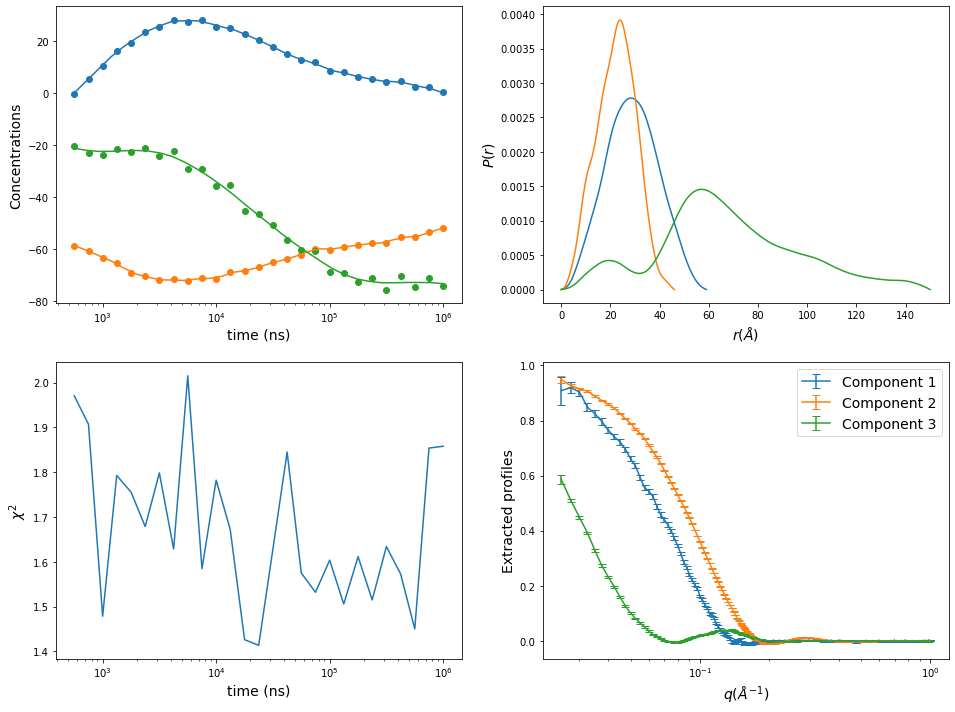

In [6]:
# plot the end results
plt.rcParams['figure.figsize'] = 16, 12
fig, axs = plt.subplots(2, 2)

#concentrations vs x
axs[0, 0].semilogx(10**x1, c1)
axs[0, 0].semilogx(10**x2, c2)
axs[0, 0].semilogx(10**x3, c3)
axs[0, 0].scatter(10**x, p1)
axs[0, 0].scatter(10**x, p2)
axs[0, 0].scatter(10**x, p3)
axs[0, 0].set_xlabel('time (ns)', fontsize=14)
axs[0, 0].set_ylabel('Concentrations', fontsize=14)

#chi2 vs x
axs[1, 0].semilogx(10**x, np.mean(resid ** 2, 0))
axs[1, 0].set_xlabel('time (ns)', fontsize=14)
axs[1, 0].set_ylabel('$\chi^2$', fontsize=14)

#P(r) vs r
axs[0, 1].plot(r1, pr1)
axs[0, 1].plot(r2, pr2)
axs[0, 1].plot(r3, pr3)
axs[0, 1].set_xlabel('$r (Å)$', fontsize=14)
axs[0, 1].set_ylabel('$P(r)$', fontsize=14)

#extracted profiles
axs[1, 1].errorbar(q, I1, sigma1, capsize=4, label='Component 1')
axs[1, 1].errorbar(q, I2, sigma2, capsize=4, label='Component 2')
axs[1, 1].errorbar(q, I3, sigma3, capsize=4, label='Component 3')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('linear')
axs[1, 1].set_xlabel('$q (Å^{-1})$', fontsize=14)
axs[1, 1].set_ylabel('Extracted profiles', fontsize=14)
plt.legend(fontsize=14)

plt.show()